Mount to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1 : Image Preprocessing and Feature Extraction (Single Image)

File: feature_extraction_single_image.py
Purpose:
This script loads a medical MRI image, preprocesses it, and extracts key statistical, texture, and edge features for AI analysis.

Key Steps:

Preprocessing: Converts image to grayscale, resizes, and normalizes it to [0,1].

Statistical features: Mean, standard deviation, variance, skewness, and kurtosis.

Texture features (GLCM): Contrast, correlation, energy, and homogeneity from gray-level co-occurrence matrix.

Edge features: Edge density using Canny edge detection.

Entropy: Measures information content (image complexity).

Output: Prints a dictionary of extracted features.

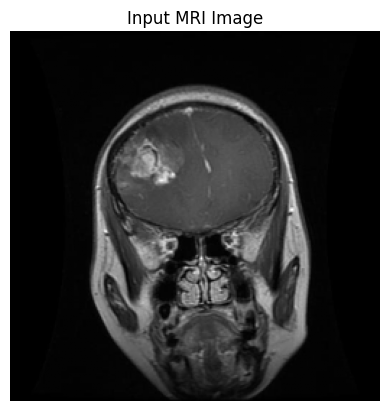


🧩 Extracted Features from Image:
mean_intensity      : 0.12341
std_intensity       : 0.16935
variance            : 0.02868
skewness            : 1.37106
kurtosis            : 1.04454
contrast            : 814.70208
correlation         : 0.95851
energy              : 0.27375
homogeneity         : 0.58511
edge_density        : 0.08983
entropy             : 5.25304


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis, entropy
import os

image_path = "/content/drive/MyDrive/brain_mri/Training/glioma/Tr-glTr_0000.jpg"

image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = cv2.resize(gray, (256, 256))

gray_norm = gray / 255.0

plt.imshow(gray_norm, cmap='gray')
plt.title("Input MRI Image")
plt.axis('off')
plt.show()


mean_intensity = np.mean(gray_norm)
std_intensity = np.std(gray_norm)
variance = np.var(gray_norm)
skewness = skew(gray_norm.flatten())
kurt = kurtosis(gray_norm.flatten())

glcm = graycomatrix((gray * 255).astype(np.uint8),
                    distances=[1],
                    angles=[0],
                    symmetric=True,
                    normed=True)

contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

edges = cv2.Canny((gray_norm * 255).astype(np.uint8), 50, 150)
edge_density = np.sum(edges > 0) / edges.size

hist, _ = np.histogram(gray_norm, bins=256, range=(0, 1))
hist = hist / np.sum(hist)
entropy_value = -np.sum(hist * np.log2(hist + 1e-10))

features = {
    "mean_intensity": mean_intensity,
    "std_intensity": std_intensity,
    "variance": variance,
    "skewness": skewness,
    "kurtosis": kurt,
    "contrast": contrast,
    "correlation": correlation,
    "energy": energy,
    "homogeneity": homogeneity,
    "edge_density": edge_density,
    "entropy": entropy_value
}

print("\n🧩 Extracted Features from Image:")
for key, value in features.items():
    print(f"{key:20s}: {value:.5f}")


Step 2 : Batch Feature Extraction from Dataset

File: batch_feature_extraction.py
Purpose:
Processes an entire dataset of MRI images and extracts statistical, texture, and edge features for each patient.

Key Steps:

Defines reusable functions for entropy and feature extraction.

Iterates through folders for each disease type (glioma, meningioma, etc.).

Extracts standardized features for every image file.

Saves a structured CSV (brain_tumor_features.csv) containing patient IDs, image paths, disease labels, and features.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops
from scipy.ndimage import sobel

def calculate_entropy(image):
    hist = np.histogram(image, bins=256, range=(0, 1))[0]
    hist = hist / (hist.sum() + 1e-10)
    return -np.sum(hist * np.log2(hist + 1e-10))

def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (128, 128))
    img = img / 255.0

    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    variance = np.var(img)
    skewness = skew(img.reshape(-1))
    kurt = kurtosis(img.reshape(-1))
    entropy = calculate_entropy(img)

    img8 = (img * 255).astype(np.uint8)
    glcm = graycomatrix(img8, [1], [0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    edges = sobel(img)
    edge_density = np.sum(edges > 0.2) / edges.size

    return [mean_intensity, std_intensity, variance, skewness, kurt, contrast, correlation, energy, homogeneity, edge_density, entropy]

def process_dataset(root_folder, output_csv):
    data = []
    patient_id = 1

    for label in os.listdir(root_folder):
        label_path = os.path.join(root_folder, label)
        if not os.path.isdir(label_path):
            continue

        for file in os.listdir(label_path):
            if file.endswith(".jpg") or file.endswith(".png"):
                file_path = os.path.join(label_path, file)
                features = extract_features(file_path)
                if features:
                    data.append([f"Patient_{patient_id}", file_path, label] + features)
                    patient_id += 1

    columns = ["patient_id", "image_path", "disease_name",
               "mean_intensity", "std_intensity", "variance", "skewness", "kurtosis",
               "contrast", "correlation", "energy", "homogeneity",
               "edge_density", "entropy"]

    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"✅ CSV created successfully: {output_csv}")
    return df

train_dir = "/content/drive/MyDrive/brain_mri/Training"
output_csv = "/content/drive/MyDrive/brain_tumor_features.csv"

df = process_dataset(train_dir, output_csv)
df.head()


✅ CSV created successfully: /content/drive/MyDrive/brain_tumor_features.csv


,patient_id,image_path,disease_name,mean_intensity,std_intensity,variance,skewness,kurtosis,contrast,correlation,energy,homogeneity,edge_density,entropy
0,Patient_1,/content/drive/MyDrive/brain_mri/Training/notu...,notumor,0.377280,0.300000,0.090000,0.510592,-1.397959,1073.754860,0.908632,0.197284,0.395459,0.147522,6.161784
1,Patient_2,/content/drive/MyDrive/brain_mri/Training/notu...,notumor,0.218424,0.201727,0.040694,0.284199,-1.215308,545.396531,0.896864,0.280684,0.386320,0.150208,5.629343
2,Patient_3,/content/drive/MyDrive/brain_mri/Training/notu...,notumor,0.142215,0.164712,0.027130,1.764224,4.025031,633.987205,0.820816,0.060453,0.232676,0.110718,5.970794
3,Patient_4,/content/drive/MyDrive/brain_mri/Training/notu...,notumor,0.351304,0.332682,0.110678,0.328189,-1.562978,1183.062192,0.917065,0.128084,0.278068,0.192566,6.831715
4,Patient_5,/content/drive/MyDrive/brain_mri/Training/notu...,notumor,0.188102,0.221814,0.049201,1.432754,1.628089,461.165723,0.928149,0.229005,0.451142,0.139771,5.864029


Ztep 3 : Statistical Analysis and Visualization

File: feature_analysis_plots.py
Purpose:
Analyzes the extracted feature dataset and visualizes how image features vary between tumor types.

Key Steps:

Reads the features CSV file.

Groups data by disease_name to calculate descriptive statistics (mean, quartiles).

Plots boxplots for contrast and entropy to show distribution per tumor type.

Saves results as .png files for reporting.

--- 📈 Statistical Summary by Tumor Type ---
             contrast                                                   \
                count         mean         std         min         25%   
disease_name                                                             
glioma         1321.0   298.805902   93.039004   46.124385  235.363435   
meningioma     1339.0   366.267411  164.542539   48.697096  281.181841   
notumor        1595.0  1107.686091  877.708138   56.525406  501.980930   
pituitary      1457.0   438.935322   94.660826  137.598364  379.692790   

                                                   entropy            ...  \
                     50%          75%          max   count      mean  ...   
disease_name                                                          ...   
glioma        297.835507   363.667446   605.605069  1321.0  5.310935  ...   
meningioma    352.025468   416.967827  1919.448942  1339.0  5.801325  ...   
notumor       843.429380  1382.618971  5506.969304  

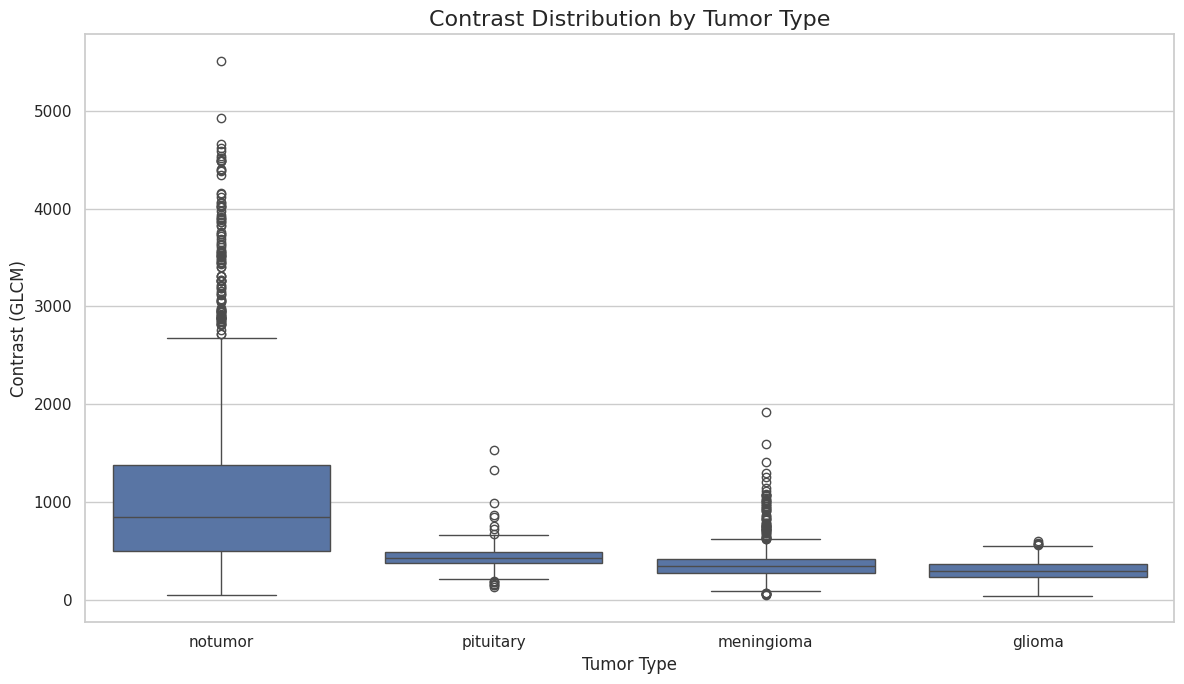

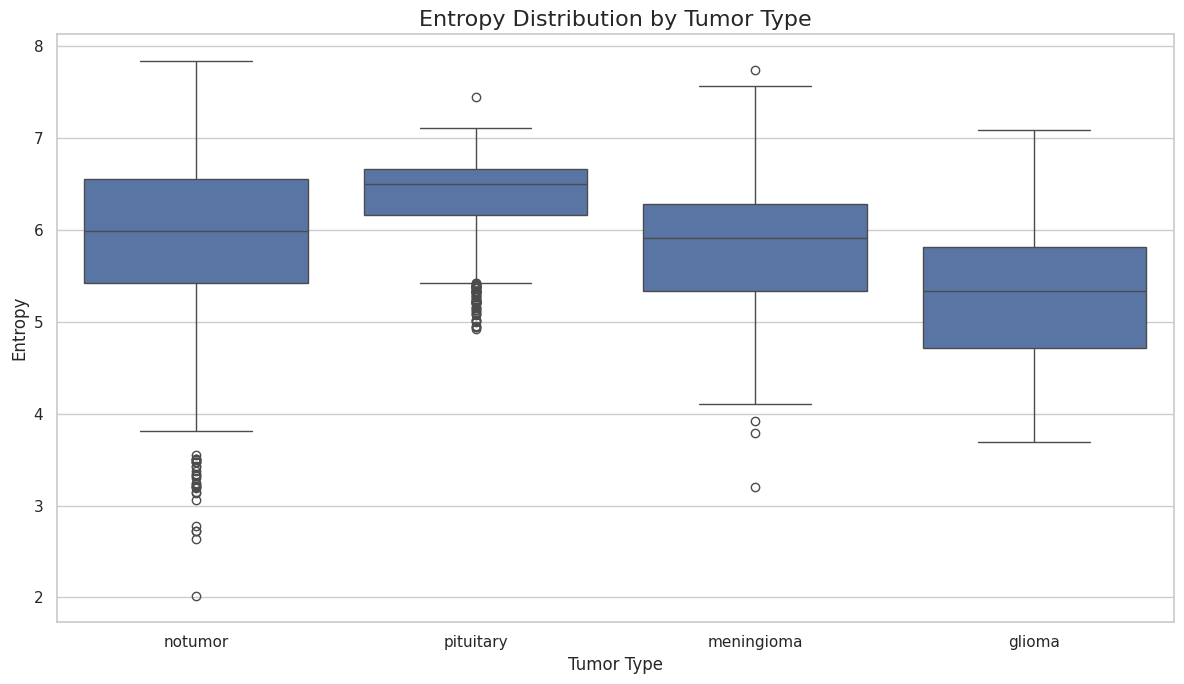

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")

file_path = "/content/drive/MyDrive/brain_tumor_features.csv"

if not os.path.exists(file_path):
    print(f"--- ❗ ERROR ---")
    print(f"File not found at path: {file_path}")
    print("Please ensure your Google Drive is mounted and the file path is correct.")
else:
    try:

        df_features = pd.read_csv(file_path)

        print("--- 📈 Statistical Summary by Tumor Type ---")

        feature_summary = df_features.groupby('disease_name')[
            ['contrast', 'entropy', 'mean_intensity', 'variance']
        ].describe()

        print(feature_summary)

        print("\n--- 🎨 Generating feature plots... ---")

        plt.figure(figsize=(12, 7))
        sns.boxplot(data=df_features, x='disease_name', y='contrast')
        plt.title('Contrast Distribution by Tumor Type', fontsize=16)
        plt.ylabel('Contrast (GLCM)')
        plt.xlabel('Tumor Type')
        plt.tight_layout()
        plt.savefig("contrast_distribution.png")
        print("Saved contrast_distribution.png")

        plt.figure(figsize=(12, 7))
        sns.boxplot(data=df_features, x='disease_name', y='entropy')
        plt.title('Entropy Distribution by Tumor Type', fontsize=16)
        plt.ylabel('Entropy')
        plt.xlabel('Tumor Type')
        plt.tight_layout()
        plt.savefig("entropy_distribution.png")
        print("Saved entropy_distribution.png")

        print("\n✅ Analysis complete. Review the printed summary table and the saved .png plot files.")
        print("Use these statistical values (mean, 25%, 50%, 75%) to set realistic thresholds in the next step.")

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check your file for issues (e.g., is it a valid CSV?).")

Step 4 : Clinical Data Generation and ICD-10 Labeling

File: clinical_data_labeling.py
Purpose:
Enhances the dataset by assigning clinical labels and ICD-10 codes based on disease type and simulated tumor grades.

Key Steps:

Reads brain_tumor_features.csv.

Applies rule-based labeling logic:

Assigns tumor subtypes, WHO grades, treatments, outcomes, and ICD-10 codes.

Randomly generates realistic glioma grades (II–IV).

Outputs a labeled dataset brain_tumor_features_with_clinical_data.csv

In [ ]:
import pandas as pd
import numpy as np
import random

file_path = "/content/drive/MyDrive/brain_tumor_features.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please ensure your Google Drive is mounted and the path is correct.")
    raise

df.fillna(0, inplace=True)

def assign_clinical_data(row):

    disease = str(row.get('disease_name', '')).strip().lower()

    if disease in ['no_tumor', 'notumor', 'normal']:
        subtype = "-"
        grade = "-"
        treatment = "-"
        outcome = "Normal brain – no abnormality detected"
        icd_10_code = "R90.82"

    elif "pituitary" in disease:
        subtype = "Pituitary Adenoma"
        grade = "I (Benign)"
        treatment = "Medication / Transsphenoidal Surgery"
        outcome = "Excellent hormonal recovery"
        icd_10_code = "D35.2"

    elif "meningioma" in disease:
        subtype = "Meningioma (Benign)"
        grade = "I (Benign)"
        treatment = "Surgical resection"
        outcome = "Excellent prognosis"
        icd_10_code = "D32.9"

    elif "glioma" in disease or "astrocytoma" in disease:
        rand_prob = random.random()

        if rand_prob < 0.4:
            subtype = "Diffuse Astrocytoma"
            grade = "II (Low-Grade)"
            treatment = "Surgery + Radiation"
            outcome = "Good prognosis, monitor for recurrence"
            icd_10_code = "C71.9"

        elif rand_prob < 0.75:
            subtype = "Anaplastic Astrocytoma"
            grade = "III (Malignant)"
            treatment = "Surgery + Radiation + Chemotherapy"
            outcome = "Moderate survival rate"
            icd_10_code = "C71.9"

        else:
            subtype = "Glioblastoma Multiforme (GBM)"
            grade = "IV (Highly Malignant)"
            treatment = "Surgery + Chemo + Radiation (Temozolomide)"
            outcome = "Poor; aggressive tumor"
            icd_10_code = "C71.9"

    else:
        subtype = "Unclassified Tumor"
        grade = "-"
        treatment = "Needs further diagnostic imaging"
        outcome = "Pending biopsy"
        icd_10_code = "D49.6"

    return pd.Series([subtype, grade, treatment, outcome, icd_10_code])

print("Applying labeling rules...")
df[['Tumor_SubType', 'Tumor_Grade', 'Treatment', 'Outcome', 'ICD_10_Code']] = df.apply(assign_clinical_data, axis=1)
print("Labeling complete.")

output_file = "/content/drive/MyDrive/brain_mri/brain_tumor_features_with_clinical_data.csv"

df.to_csv(output_file, index=False, encoding='utf-8')

print(f"✅ Labeled dataset saved successfully to: {output_file}")
print("\n📊 Sample Output:")

print("--- Sample 'notumor' ---")
print(df[df['disease_name'] == 'notumor'].head(3))
print("\n--- Sample 'glioma' (Note the random grades) ---")
print(df[df['disease_name'] == 'glioma'].head(5))
print("\n--- Sample 'meningioma' ---")
print(df[df['disease_name'] == 'meningioma'].head(3))
print("\n--- Sample 'pituitary' ---")
print(df[df['disease_name'] == 'pituitary'].head(3))

Applying labeling rules...
Labeling complete.
✅ Labeled dataset saved successfully to: /content/drive/MyDrive/brain_mri/brain_tumor_features_with_clinical_data.csv

📊 Sample Output:
--- Sample 'notumor' ---
  patient_id                                         image_path disease_name  \
0  Patient_1  /content/drive/MyDrive/brain_mri/Training/notu...      notumor   
1  Patient_2  /content/drive/MyDrive/brain_mri/Training/notu...      notumor   
2  Patient_3  /content/drive/MyDrive/brain_mri/Training/notu...      notumor   

   mean_intensity  std_intensity  variance  skewness  kurtosis     contrast  \
0        0.377280       0.300000  0.090000  0.510592 -1.397959  1073.754860   
1        0.218424       0.201727  0.040694  0.284199 -1.215308   545.396531   
2        0.142215       0.164712  0.027130  1.764224  4.025031   633.987205   

   correlation    energy  homogeneity  edge_density   entropy Tumor_SubType  \
0     0.908632  0.197284     0.395459      0.147522  6.161784             - 

Step 5 : Purpose:
Verifies dataset consistency and provides a summary of disease distribution after clinical labeling.

Key Steps:

Loads the labeled dataset with encoding safety checks.

Cleans text inconsistencies.

Displays summary statistics for disease and tumor subtype distributions.

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/brain_mri/brain_tumor_features_with_clinical_data.csv"

try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')

df['disease_name'] = df['disease_name'].astype(str).str.strip().str.lower()
df['Tumor_SubType'] = df['Tumor_SubType'].astype(str).str.strip()

print("✅ Dataset loaded successfully!")
print("🔹 Total rows:", len(df))
print("🔹 Columns:", list(df.columns))

print("\n📊 Disease name distribution:\n", df['disease_name'].value_counts())
print("\n📊 Tumor subtype distribution:\n", df['Tumor_SubType'].value_counts())

print("\n📊 Detailed disease + subtype summary:\n")
group_summary = df.groupby(['disease_name', 'Tumor_SubType']).size().reset_index(name='count')
print(group_summary)


✅ Dataset loaded successfully!
🔹 Total rows: 5712
🔹 Columns: ['patient_id', 'image_path', 'disease_name', 'mean_intensity', 'std_intensity', 'variance', 'skewness', 'kurtosis', 'contrast', 'correlation', 'energy', 'homogeneity', 'edge_density', 'entropy', 'Tumor_SubType', 'Tumor_Grade', 'Treatment', 'Outcome', 'ICD_10_Code']

📊 Disease name distribution:
 disease_name
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

📊 Tumor subtype distribution:
 Tumor_SubType
-                                1595
Pituitary Adenoma                1457
Meningioma (Benign)              1339
Diffuse Astrocytoma               531
Anaplastic Astrocytoma            455
Glioblastoma Multiforme (GBM)     335
Name: count, dtype: int64

📊 Detailed disease + subtype summary:

  disease_name                  Tumor_SubType  count
0       glioma         Anaplastic Astrocytoma    455
1       glioma            Diffuse Astrocytoma    531
2       glioma  Glioblastoma

Step 6 : Data Cleaning and Balancing
Purpose:
Cleans the labeled dataset and ensures an equal number of samples per tumor subtype.

Key Steps:

Fixes special character issues (â€“, Ã, etc.).

Normalizes text fields.

Randomly samples equal rows for each subtype

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/brain_mri/brain_tumor_features_with_clinical_data.csv"

try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')

df.replace({
    r'â€“': ' ',
    r'Ã©': 'é',
    r'Ã': 'A',
    r'Â': '',
    r'‘': "'",

}, regex=True, inplace=True)

for col in ['disease_name', 'Tumor_SubType', 'Tumor_Grade', 'Treatment', 'Outcome', 'ICD_10_Code']:
    df[col] = df[col].astype(str).str.strip()

df['Outcome'] = df['Outcome'].replace({
    'Normal brain – no abnormality detected': 'Normal brain - no abnormality detected',
    'Normal brain â€“ no abnormality detected': 'Normal brain - no abnormality detected'
})

subtypes = df['Tumor_SubType'].unique()
print("🎯 Subtypes found:", subtypes)

target_per_subtype = 400 // len(subtypes)
print(f"📉 Sampling {target_per_subtype} samples per subtype (≈ total 400)")

sampled_dfs = []
for subtype in subtypes:
    subtype_df = df[df['Tumor_SubType'] == subtype]
    n = min(target_per_subtype, len(subtype_df))
    sampled_dfs.append(subtype_df.sample(n=n, random_state=42))

balanced_df = pd.concat(sampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ Balanced dataset created successfully!")
print("🔹 Total rows:", len(balanced_df))
print("🔹 Distribution per subtype:\n", balanced_df['Tumor_SubType'].value_counts())

output_path = "/content/drive/MyDrive/brain_mri/brain_tumor_features_balanced_400.csv"
balanced_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n✅ Final balanced dataset saved to: {output_path}")


🎯 Subtypes found: ['-' 'Pituitary Adenoma' 'Meningioma (Benign)'
 'Glioblastoma Multiforme (GBM)' 'Diffuse Astrocytoma'
 'Anaplastic Astrocytoma']
📉 Sampling 66 samples per subtype (≈ total 400)

✅ Balanced dataset created successfully!
🔹 Total rows: 396
🔹 Distribution per subtype:
 Tumor_SubType
Pituitary Adenoma                66
Diffuse Astrocytoma              66
Glioblastoma Multiforme (GBM)    66
-                                66
Anaplastic Astrocytoma           66
Meningioma (Benign)              66
Name: count, dtype: int64

✅ Final balanced dataset saved to: /content/drive/MyDrive/brain_mri/brain_tumor_features_balanced_400.csv


Step 6: Final Data Cleaning and Patient ID Assignment
Purpose:
Creates a final clean version of the dataset ready for modeling and documentation.

Key Steps:

Replaces invalid characters in key text columns.

Adds continuous patient IDs (Patient_01, Patient_02, …).

Saves the final cleaned file brain_tumor_info.csv.

Prints preview and verifies data integrity.

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/brain_mri/brain_tumor_features_balanced_400.csv"
df = pd.read_csv(file_path)

for col in ["Tumor_SubType", "Tumor_Grade", "Treatment"]:
    df[col] = df[col].astype(str).replace({"-": "No", "â€“": "No", "–": "No"})

df = df.reset_index(drop=True)
df["patient_id"] = ["Patient_" + str(i + 1).zfill(2) for i in range(len(df))]

cleaned_path = "/content/drive/MyDrive/brain_mri/brain_tumor_info.csv"
df.to_csv(cleaned_path, index=False)

print("✅ Data cleaned and patient IDs updated successfully!")
print(f"💾 Saved to: {cleaned_path}\n")
print("📋 Preview:")
print(df.head())

print("\n🔍 Unique values in Tumor_SubType:")
print(df["Tumor_SubType"].unique())


✅ Data cleaned and patient IDs updated successfully!
💾 Saved to: /content/drive/MyDrive/brain_mri/brain_tumor_info.csv

📋 Preview:
   patient_id                                         image_path disease_name  \
0  Patient_01  /content/drive/MyDrive/brain_mri/Training/pitu...    pituitary   
1  Patient_02  /content/drive/MyDrive/brain_mri/Training/glio...       glioma   
2  Patient_03  /content/drive/MyDrive/brain_mri/Training/glio...       glioma   
3  Patient_04  /content/drive/MyDrive/brain_mri/Training/notu...      notumor   
4  Patient_05  /content/drive/MyDrive/brain_mri/Training/glio...       glioma   

   mean_intensity  std_intensity  variance  skewness  kurtosis    contrast  \
0        0.219672       0.160890  0.025886  0.771439  0.756741  487.590182   
1        0.154447       0.147137  0.021649  1.046972  1.052798  398.412217   
2        0.125582       0.140144  0.019640  1.134602  1.095372  263.332062   
3        0.209335       0.267116  0.071351  1.193330  0.235325  777.67